In [1]:
%reset
%pylab inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Populating the interactive namespace from numpy and matplotlib


In [1]:
import pandas as pd
import os
import scipy.io as spio
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import brewer2mpl
import scipy.stats as stats
#import seaborn as sns

import loadmat
import brewer2mpl
from __future__ import division
import os
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

In [25]:
#RT differences between antonym generation and word repetition 
for subj in ['GP15', 'GP35']:
    EmoGen = dfall[(dfall.subj == subj) & (dfall.task == 'EmoGen')].RTs
    EmoRep = dfall[(dfall.subj == subj) & (dfall.task == 'EmoRep')].RTs
    t, p = stats.ttest_ind(EmoGen.values, EmoRep.values)
    print (subj, t, p, EmoGen.shape, EmoRep.shape)
    
    
subj = 'JH2'
EmoGen = dfall[(dfall.subj == subj) & (dfall.task == 'EmoGen')].RTs
SelfAud = dfall[(dfall.subj == subj) & (dfall.task == 'SelfAud')].RTs
t, p = stats.ttest_ind(EmoGen.values, SelfAud.values)
print (subj, t, p)



('GP15', 15.078074553260079, 2.6348166550987708e-37, (147,), (114,))
('GP35', 8.7702431169741164, 1.6382778264367603e-15, (90,), (85,))
('JH2', 4.5466419616214422, 1.3286883157609143e-05)


In [5]:
#calulate RTs for JH2 EmoRep
subj, task, srate = ('JH2','EmoRep', 1000)

#load onsets_stim and onsets_resp
filenames = glob.glob(os.path.join(SJdir, 'Subjs', subj, task, 'onsets*.mat'))
filenames = [s for s in filenames if 'empty' not in s]

data_dict = dict()
for f in filenames:
    data_dict.update(loadmat.loadmat(f))

varnames = [x.split('/')[-1].split('.')[0] for x in filenames]
varnames.remove('onsets_cue') if 'onsets_cue' in varnames else 1 #drop onsets_cue for my data

#assign onsets_stim and _resp to correct variables (hacky because of weird naming structure in orig data)
idx = ['resp' in x for x in varnames]
idx_resp = [i for i, elem in enumerate(idx) if elem][0]
idx_stim = [i for i, elem in enumerate(idx) if not(elem)][0]

tmp = [data_dict.get(k) for k in varnames]
onsets_resp = tmp[idx_resp]
onsets_stim = tmp[idx_stim]

RTs = onsets_resp - onsets_stim
goodidx = (RTs > (RTs.mean() - 3 * RTs.std())) & (RTs < RTs.mean() + 3 * RTs.std())
onsets_resp = onsets_resp[goodidx]
onsets_stim = onsets_stim[goodidx]

onsets_resp = onsets_resp/srate*1000
onsets_stim = onsets_stim/srate*1000

#load stimulus duration for auditory tasks with variable durations
if (task == 'SelfAud') | (task == 'EmoRep') | (task == 'EmoGen'):
    filename = os.path.join(SJdir, 'Subjs', subj, task, 'stim_dur.mat')
    data_dict = loadmat.loadmat(filename)
    stim_dur = data_dict['stim_dur']
    stim_dur = stim_dur[goodidx]
else:
    stim_dur = np.tile(stim_dur_dict[task], onsets_stim.size)


RT_offsets = onsets_resp - (onsets_stim + stim_dur)

In [11]:
pd.DataFrame(RTs[goodidx]).sem()

0    9.079049
dtype: float64

In [24]:
EmoGen = dfall[(dfall.subj == subj) & (dfall.task == 'EmoGen')].RTs
EmoRep = RT_offsets
t, p = stats.ttest_ind(EmoGen.values, EmoRep)
print (subj, t, p, EmoGen.shape, EmoRep.shape)



('JH2', 14.742157291432736, 1.4566427817389257e-30, (63,), (83,))


## RT hists in 50 ms bins from stim offset

In [3]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
reconlist = os.path.join(SJdir, 'PCA', 'reconlist_pruned.csv')
reconlist = pd.read_csv(reconlist)

filename = os.path.join(SJdir,'PCA', 'RTs','RT_summary_offsets.csv')
dfRT = pd.read_csv(filename)

tmp = dfRT.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


task
FaceGen         326.972271
FaceEmo         343.521582
DecisionVis     362.477948
EmoRep          450.391355
DecisionAud     970.304267
SelfAud        1005.175139
SelfVis        1060.270927
EmoGen         1408.861925
Name: RTs_mean, dtype: float64

In [5]:
stim_dur_dict = {'DecisionAud':600, 'DecisionVis':500, 'FaceEmo':300, 'FaceGen':300, 'SelfVis':400}
#from offset
dfall = pd.DataFrame()
df = pd.DataFrame()
for x in reconlist.values:
    subj_task, recon, _,srate, _ = x
    
    if (isinstance(recon, float)): #no recon
        continue
        
    subj, task = subj_task.split('_')

    #load onsets_stim and onsets_resp
    filenames = glob.glob(os.path.join(SJdir, 'Subjs', subj, task, 'onsets*.mat'))
    filenames = [s for s in filenames if 'empty' not in s]
    
    data_dict = dict()
    for f in filenames:
        data_dict.update(loadmat.loadmat(f))
        
    varnames = [x.split('/')[-1].split('.')[0] for x in filenames]
    varnames.remove('onsets_cue') if 'onsets_cue' in varnames else 1 #drop onsets_cue for my data
    
    #assign onsets_stim and _resp to correct variables (hacky because of weird naming structure in orig data)
    idx = ['resp' in x for x in varnames]
    idx_resp = [i for i, elem in enumerate(idx) if elem][0]
    idx_stim = [i for i, elem in enumerate(idx) if not(elem)][0]

    tmp = [data_dict.get(k) for k in varnames]
    onsets_resp = tmp[idx_resp]
    onsets_stim = tmp[idx_stim]
    
    RTs = onsets_resp - onsets_stim
    goodidx = (RTs > (RTs.mean() - 3 * RTs.std())) & (RTs < RTs.mean() + 3 * RTs.std())
    onsets_resp = onsets_resp[goodidx]
    onsets_stim = onsets_stim[goodidx]
        
    onsets_resp = onsets_resp/srate*1000
    onsets_stim = onsets_stim/srate*1000
    
    #load stimulus duration for auditory tasks with variable durations
    if (task == 'SelfAud') | (task == 'EmoRep') | (task == 'EmoGen'):
        filename = os.path.join(SJdir, 'Subjs', subj, task, 'stim_dur.mat')
        data_dict = loadmat.loadmat(filename)
        stim_dur = data_dict['stim_dur']
        stim_dur = stim_dur[goodidx]
    else:
        stim_dur = np.tile(stim_dur_dict[task], onsets_stim.size)

    
    RT_offsets = onsets_resp - (onsets_stim + stim_dur)
    
    df = pd.DataFrame({'subj': np.tile(subj, RT_offsets.shape), 'task':np.tile(task, RT_offsets.shape), 'RTs':RT_offsets})
    dfall = dfall.append(df)

In [6]:
#create dataframe
RTs_n = list(); RTs_mean = list(); RTs_std = list(); RTs_range = list(); RTs_skew = list(); subjs = list(); tasks = list()

for r in dfall.groupby(['subj','task']):
    s, t = r[0]
    RTs = r[1]['RTs']
    RTs_mean.append(RTs.mean())
    RTs_std.append(RTs.std())
    RTs_range.append((max(RTs)-min(RTs)))
    RTs_skew.append(stats.kurtosis(RTs))
    RTs_n.append(len(RTs))
    subjs.append(s)
    tasks.append(t)

df = pd.DataFrame()
df['subj'] = subjs
df['task'] = tasks
df['RTs_mean'] = RTs_mean
df['RTs_std'] = RTs_std
df['RTs_range'] = RTs_range
df['RTs_skew'] = RTs_skew

tmp = df.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


task
DecisionVis     265.509809
FaceGen         326.972271
FaceEmo         343.521582
EmoRep          474.901550
DecisionAud     954.727233
SelfAud        1044.463068
SelfVis        1060.270927
EmoGen         1408.861925
Name: RTs_mean, dtype: float64

In [6]:
names_dict = {'DecisionAud' : 'Categorization\nAuditory', \
              'DecisionVis' : 'Categorization\nVisual', \
             'EmoGen' : 'Antonym\nGeneration', \
             'EmoRep' : 'Word\nRepetition', \
             'FaceEmo' :'Face Emotion\nDiscrimination', \
             'FaceGen' : 'Face Gender\nDiscrimination', \
             'SelfAud' : 'Self Referential\nAuditory', \
             'SelfVis' : 'Self Referential\nVisual'}

In [7]:
num_tasks = len(df.groupby('task').count().index)

In [8]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.transforms import blended_transform_factory

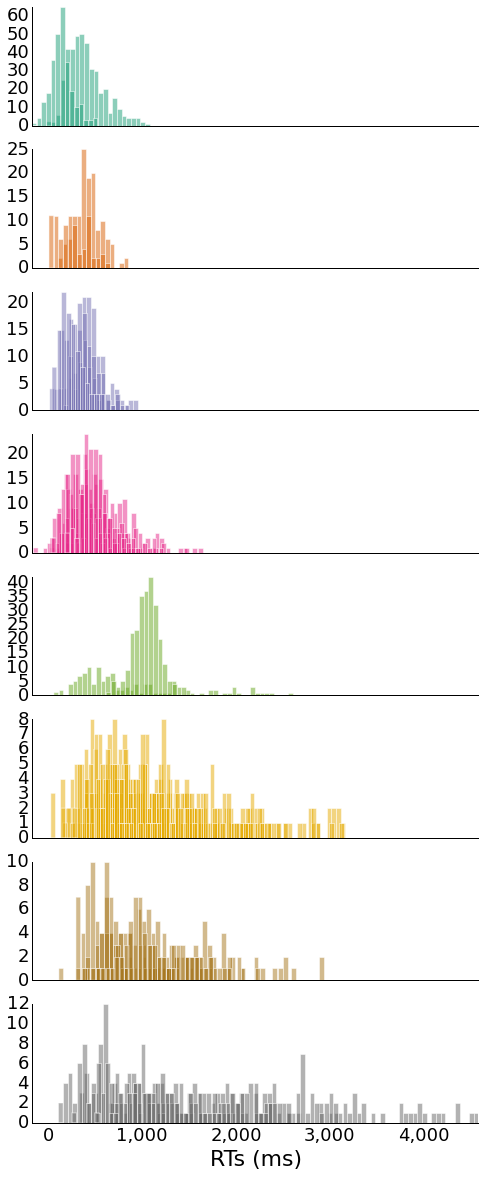

In [11]:
set2 = brewer2mpl.get_map('Dark2', 'Qualitative', num_tasks).mpl_colors
fig, ax = plt.subplots(num_tasks,sharex=True, figsize = (8, 20),subplot_kw=dict(axisbg='#EEEEEE'))
plt.tight_layout

left, width = .25, .75
bottom, height = .25, .70
right = left + width
top = bottom + height


for i, t in enumerate(tmp.index):
    ax[i].patch.set_facecolor('white')

    ax[i].autoscale(tight=True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    ax[i].yaxis.set_tick_params(labelsize = 18, width = 0)
    ax[i].xaxis.set_tick_params(labelsize = 18, width = 0)
    #majorLocator   = MultipleLocator(5)
    #majorFormatter = FormatStrFormatter('%d')
    
    #ax[i].yaxis.set_major_locator(majorLocator)
    #ax[i].yaxis.set_major_formatter(majorFormatter)

#     ax[i].text(right, top, names_dict[t],
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax[i].transAxes, fontsize = 24, weight = 'bold')    
    
    #ax[i].set_ylabel('Trials', fontsize = 24, weight = 'bold')
    
    
for i, task in enumerate(tmp.index): #ordered by increasing mean
    data = dfall.loc[dfall['task'] == task].dropna()
    
    for s in data.groupby('subj'):
        data = s[1]['RTs']
        binwidth = 50
        ax[i].hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), color = set2[i], alpha = 0.5, edgecolor = 'white')
        #x = s[1]['RTs'].hist(ax = ax[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white', label = s[0])
        #x.legend()
        mn = df.groupby('task').mean().loc[task]['RTs_mean']
        sd = df.groupby('task').mean().loc[task]['RTs_std']
        label = 'MN = %.2f\nSD = %.2f' %(mn, sd)
#         tform = blended_transform_factory(ax[i].transData, ax[i].transAxes)
#         ax[i].annotate(label, xy=(3500, 0), xycoords=tform, 
#             xytext=(3500, 0.8), textcoords=tform, fontsize=18,
#             ha='center', va='center')
        ax[i].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[i].set_xlabel('RTs (ms)',fontsize = 22)
                
plt.savefig(os.path.join(SJdir, 'PCA', 'Figures','RT_hists_alpha_offset_nolabel_commas.png'), transparent = True, dpi = 150)        

## mean and STD of all tasks all subjects

In [ ]:
datadir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/'

reconlist = os.path.join(datadir, 'PCA', 'reconlist.csv')
reconlist = pd.read_csv(reconlist)
#reconlist = pd.ExcelFile(reconlist).parse('Sheet1')

In [4]:
subjs = list(); tasks = list()
for x in reconlist.subj_task:
    s, t = x.split('_')
    subjs.append(s)
    tasks.append(t)
    
df = pd.DataFrame({'subj':subjs, 'task':tasks})

In [15]:
#write csv
RTs_n = list(); RTs_mean = list(); RTs_std = list(); RTs_range = list(); RTs_skew = list(); subjs = list(); tasks = list()

for r in dfall.groupby(['subj','task']):
    s, t = r[0]
    RTs = r[1]['RTs']
    RTs_mean.append(RTs.mean())
    RTs_std.append(RTs.std())
    RTs_range.append((max(RTs)-min(RTs)))
    RTs_skew.append(stats.kurtosis(RTs))
    RTs_n.append(len(RTs))
    subjs.append(s)
    tasks.append(t)

df = pd.DataFrame()
df['subj'] = subjs
df['task'] = tasks
df['RTs_mean'] = RTs_mean
df['RTs_std'] = RTs_std
df['RTs_range'] = RTs_range
df['RTs_skew'] = RTs_skew
df['RTs_n'] = RTs_n



In [30]:
print min(df.RTs_n)
print median(df.RTs_n)
df.sort('RTs_n').head()

43
89.0


,subj,task,RTs_mean,RTs_std,RTs_range,RTs_skew,RTs_n
39,ST6,SelfAud,1688.015638,808.086307,2808.543267,0.736757,43
25,JH2,SelfVis,1642.440000,468.329082,2154.000000,-0.188063,50
19,JH17,EmoRep,1170.040000,111.239943,466.000000,-0.118301,50
24,JH2,SelfAud,1597.421053,333.110286,1154.000000,-1.149905,57
20,JH17,SelfAud,1592.688525,435.118472,1854.000000,0.038835,61


In [17]:
filename = os.path.join(SJdir, 'PCA', 'RT_summary.csv')
df.to_csv(filename)

## number of trials in original onsets

In [23]:
import glob

In [22]:
datadir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

reconlist = os.path.join(datadir, 'PCA', 'reconlist.xlsx')
reconlist = pd.ExcelFile(reconlist).parse('Sheet1')

subjs = list(); tasks = list()
for x in reconlist.subj_task:
    s, t = x.split('_')
    subjs.append(s)
    tasks.append(t)
    
df = pd.DataFrame({'subj':subjs, 'task':tasks})

onsets_n = list()

for i, s, t in df.itertuples(index=True):
    filename = glob.glob(os.path.join(datadir, 'Subjs', s, t, 'onsets*mat'))[0]
    data = spio.loadmat(filename, struct_as_record = True)
    varname = filename.split('/')[-1].split('.')[0]
    onsets = data[varname]
    onsets_n.append(len(onsets))

In [26]:
df['num_trials'] = onsets_n
df.to_csv(os.path.join(datadir, 'PCA', 'numtrials_orig.csv'))

##histogram of all RTs for all tasks for all subjects (in reconlist)

In [126]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [11]:
from __future__ import division
import loadmat
import os
import pandas as pd
import numpy as np

In [12]:
SJdir = '/Users/matar/Documents/MATLAB/DATA/Avgusta/'
groupidx = os.path.join(SJdir, 'PCA','hclust', 'groupidx_hclust.csv')
df = pd.read_csv(groupidx)

In [13]:
reconlist = os.path.join(SJdir, 'PCA', 'reconlist.csv')
#reconlist = pd.ExcelFile(reconlist).parse('Sheet1')
reconlist = pd.read_csv(reconlist)

In [14]:
dfall = pd.DataFrame()
df = pd.DataFrame()
for x in reconlist.values:
    subj_task, recon, _, _, _ = x
    if (isinstance(recon, float)): #no recon
        continue
    subj, task = subj_task.split('_')

    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_percent.mat')
    data = loadmat.loadmat(filename)
    srate = data['srate']
    RT = data['RTs'].flatten()/srate*1000 #convert to ms
    
    if task == 'DecisionAud': #shift by cue (HGmtx includes cue in RT for plotting)
        RT = RT - 600
    if task == 'DecisionVis':
        RT = RT - 500
    
    df = pd.DataFrame({'subj': np.tile(subj, RT.shape), 'task':np.tile(task, RT.shape), 'RTs':RT})
    dfall = dfall.append(df)

In [120]:
#all values grouped together
means = dfall.groupby('task').mean()
means.columns = ['RT_means']

stds = dfall.groupby('task').std()
stds.columns = ['RT_stds']

medians = dfall.groupby('task').median()
medians.columns = ['RT_medians']

maxes = dfall.groupby('task').max()
maxes = maxes[['RTs']]
mins = dfall.groupby('task').min()
mins = mins[['RTs']]
maxes.columns = ['RT_max']
mins.columns = ['RT_min']


In [24]:
filename = os.path.join(SJdir, 'PCA', 'RT_task_summary.csv')
df = means.join(stds).join(medians).join(maxes).join(mins)
df.to_csv(filename)

In [125]:
#first grouped by subject
means = dfall.groupby(['subj', 'task']).apply(np.mean).reset_index().groupby('task').mean()
means.columns = ['RT_means']
stds = dfall.groupby(['subj', 'task']).apply(np.std).reset_index().groupby('task').mean()
stds.columns = ['RT_stds']

In [124]:
means

,RT_means
task,
DecisionAud,1570.304267
DecisionVis,862.477948
EmoGen,2050.275605
EmoRep,1093.796005
FaceEmo,643.524249
FaceGen,626.967915
SelfAud,1683.114688
SelfVis,1460.247057


In [69]:
dfall.groupby(['subj','task']).std().reset_index().groupby('task').mean().sort('RTs') #mean of stds across tasks

,RTs
task,
FaceEmo,145.213466
FaceGen,151.336407
EmoRep,166.792106
DecisionVis,244.418239
DecisionAud,416.025938
SelfVis,429.441116
SelfAud,509.861045
EmoGen,703.355678


In [132]:
import brewer2mpl
import matplotlib.pyplot as plt

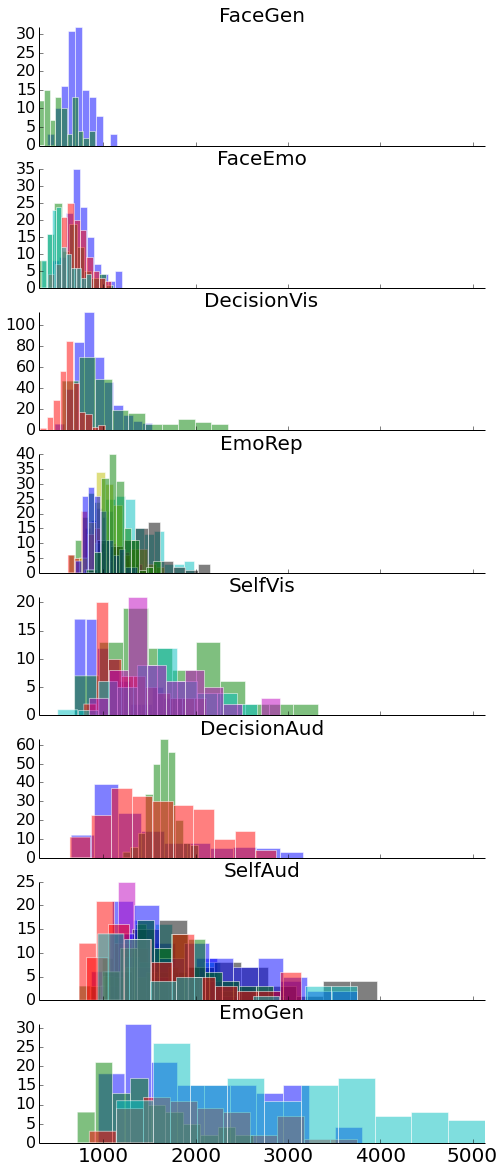

In [137]:
tmp = dfall.groupby('task').mean().sort('RTs')
tmp.index

set2 = brewer2mpl.get_map('RdBu', 'Diverging', 8).mpl_colors
fig, ax = plt.subplots(8,sharex=True, figsize = (8, 20),subplot_kw=dict(axisbg='#EEEEEE'))
plt.tight_layout

for i, t in enumerate(tmp.index):
    ax[i].set_title(t, fontsize = 20)
    ax[i].patch.set_facecolor('white')

    ax[i].autoscale(tight=True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    
for i, task in enumerate(tmp.index): #ordered by increasing mean
    data = dfall.loc[dfall['task'] == task].dropna()
    
    for s in data.groupby('subj'):
        #s[1]['RTs'].hist(ax = ax[i], color = set2[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white')
        x = s[1]['RTs'].hist(ax = ax[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white', label = s[0])
        #x.legend()
plt.savefig(os.path.join(SJdir, 'PCA', 'figs_for_Bob','RT_hists_alpha.png'))        

## calculate RTs from offset

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [9]:
import pandas as pd
import glob
import os
import loadmat
import brewer2mpl
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [10]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

In [11]:
reconlist = os.path.join(SJdir, 'PCA', 'reconlist.csv')
reconlist = pd.read_csv(reconlist)

In [16]:
tmp = dfall.groupby('task').mean().sort('RTs')
tmp['RTs']

task
FaceGen         347.369159
FaceEmo         348.817391
DecisionVis     360.464865
EmoRep          442.879739
DecisionAud     992.093333
SelfAud        1012.516042
SelfVis        1050.371794
EmoGen         1484.611234
Name: RTs, dtype: float64

In [12]:
stim_dur_dict = {'DecisionAud':600, 'DecisionVis':500, 'FaceEmo':300, 'FaceGen':300, 'SelfVis':400}
dfall = pd.DataFrame()
df = pd.DataFrame()
for x in reconlist.values:
    subj_task, recon, _,srate, _ = x
    
    if (isinstance(recon, float)): #no recon
        continue
        
    subj, task = subj_task.split('_')

    #load onsets_stim and onsets_resp
    filenames = glob.glob(os.path.join(SJdir, 'Subjs', subj, task, 'onsets*.mat'))
    
    data_dict = dict()
    for f in filenames:
        data_dict.update(loadmat.loadmat(f))
        
    varnames = [x.split('/')[-1].split('.')[0] for x in filenames]
    varnames.remove('onsets_cue') if 'onsets_cue' in varnames else 1 #drop onsets_cue for my data
    
    #assign onsets_stim and _resp to correct variables (hacky because of weird naming structure in orig data)
    idx = ['resp' in x for x in varnames]
    idx_resp = [i for i, elem in enumerate(idx) if elem][0]
    idx_stim = [i for i, elem in enumerate(idx) if not(elem)][0]

    tmp = [data_dict.get(k) for k in varnames]
    onsets_resp = tmp[idx_resp]
    onsets_stim = tmp[idx_stim]
    
    RTs = onsets_resp - onsets_stim
    goodidx = (RTs > (RTs.mean() - 3 * RTs.std())) & (RTs < RTs.mean() + 3 * RTs.std())
    onsets_resp = onsets_resp[goodidx]
    onsets_stim = onsets_stim[goodidx]
        
    onsets_resp = onsets_resp/srate*1000
    onsets_stim = onsets_stim/srate*1000
    
    #load stimulus duration for auditory tasks with variable durations
    if (task == 'SelfAud') | (task == 'EmoRep') | (task == 'EmoGen'):
        filename = os.path.join(SJdir, 'Subjs', subj, task, 'stim_dur.mat')
        data_dict = loadmat.loadmat(filename)
        stim_dur = data_dict['stim_dur']
        stim_dur = stim_dur[goodidx]
    else:
        stim_dur = np.tile(stim_dur_dict[task], onsets_stim.size)

    RT_offsets = onsets_resp - (onsets_stim + stim_dur)
    
    df = pd.DataFrame({'subj': np.tile(subj, RT_offsets.shape), 'task':np.tile(task, RT_offsets.shape), 'RTs':RT_offsets})
    dfall = dfall.append(df)

In [18]:
#create dataframe
RTs_n = list(); RTs_mean = list(); RTs_std = list(); RTs_range = list(); RTs_skew = list(); subjs = list(); tasks = list()

for r in dfall.groupby(['subj','task']):
    s, t = r[0]
    RTs = r[1]['RTs']
    RTs_mean.append(RTs.mean())
    RTs_std.append(RTs.std())
    RTs_range.append((max(RTs)-min(RTs)))
    RTs_skew.append(stats.kurtosis(RTs))
    RTs_n.append(len(RTs))
    subjs.append(s)
    tasks.append(t)

df = pd.DataFrame()
df['subj'] = subjs
df['task'] = tasks
df['RTs_mean'] = RTs_mean
df['RTs_std'] = RTs_std
df['RTs_range'] = RTs_range
df['RTs_skew'] = RTs_skew



In [20]:
tmp = df.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

task
FaceGen         326.972271
FaceEmo         343.521582
DecisionVis     362.477948
EmoRep          450.391355
DecisionAud     970.304267
SelfAud        1005.175139
SelfVis        1060.270927
EmoGen         1408.861925
Name: RTs_mean, dtype: float64

In [111]:
#write csv
filename = os.path.join(SJdir, 'PCA', 'RT_summary_offsets.csv')
df.to_csv(filename)

In [112]:
dfall.groupby('task').mean().sort('RTs')


,RTs
task,
FaceGen,347.369159
FaceEmo,348.817391
DecisionVis,360.464865
EmoRep,442.879739
DecisionAud,992.093333
SelfAud,1012.516042
SelfVis,1050.371794
EmoGen,1484.611234


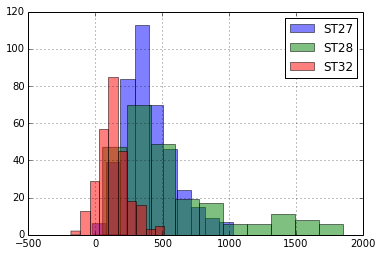

In [106]:
data = dfall.loc[(dfall.task == 'DecisionVis')][['subj','task','RTs']]
for s in data.groupby('subj'):
        x = s[1]['RTs'].hist(label = s[0], alpha = 0.5)
        x.legend()
plt.savefig(os.path.join(SJdir, 'PCA', 'RT_hist_DecisionVis_2.png'))

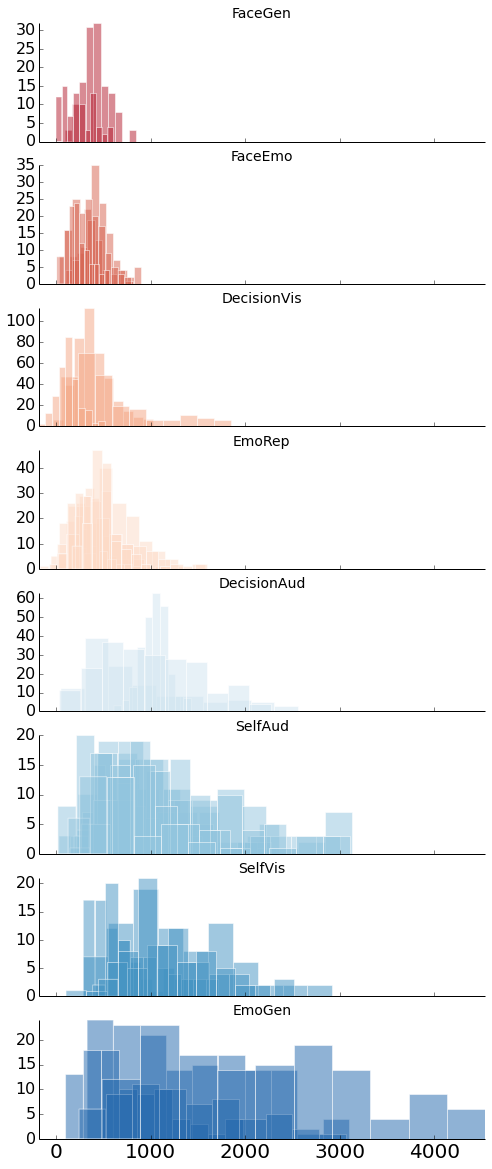

In [109]:
tmp = dfall.groupby('task').mean().sort('RTs')
tmp.index

set2 = brewer2mpl.get_map('RdBu', 'Diverging', 8).mpl_colors
fig, ax = plt.subplots(8,sharex=True, figsize = (8, 20),subplot_kw=dict(axisbg='#EEEEEE'))
plt.tight_layout

for i, t in enumerate(tmp.index):
    ax[i].set_title(t, fontsize = 14)
    #ax[i].set_frame_on(False)
    ax[i].patch.set_facecolor('white')

    ax[i].autoscale(tight=True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()

for i, task in enumerate(tmp.index): #ordered by increasing mean
    data = dfall.loc[dfall['task'] == task].dropna()
    
    for s in data.groupby('subj'):
        s[1]['RTs'].hist(ax = ax[i], color = set2[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white')
        #x = s[1]['RTs'].hist(ax = ax[i], alpha = 0.5, grid = False, xlabelsize = 20, ylabelsize = 16, edgecolor = 'white', label = s[0])
        #x.legend()
        
        
plt.savefig(os.path.join(SJdir, 'PCA', 'RT_offsets_hists.png'))        

## OLD

In [125]:
#data frame of RTs per task per subject
tasklist = zip(*[subjlist, tasklistB])
type(RTlist[0])

numpy.ndarray

In [130]:
idx = pd.MultiIndex.from_tuples(tasklist, names = ['subj','task'])
df = pd.DataFrame(RTlist,index = idx)
df = df.squeeze()
#df = pd.Panel.from_dict(d).to_frame()
#df = df.transpose()

In [128]:

#mi = pd.MultiIndex(levels = subjlist, labels = RTlist)
#df.groupby(['subj','task']).size().reindex(index = idx).fillna(0)

In [73]:
EmoRep = df.select(lambda x: x[1]=='EmoRep', axis=1)
EmoGen = df.select(lambda x: x[1]=='EmoGen', axis=1)
FaceEmo = df.select(lambda x: x[1]=='FaceEmo', axis=1)
FaceGen = df.select(lambda x: x[1]=='FaceGen', axis=1)
SelfAud = df.select(lambda x: x[1]=='SelfAud', axis=1)
SelfVis = df.select(lambda x: x[1]=='SelfVis', axis=1)

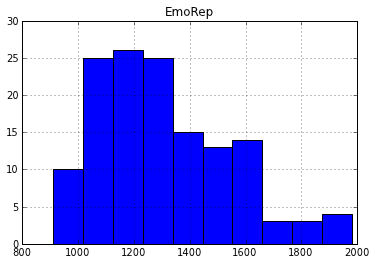

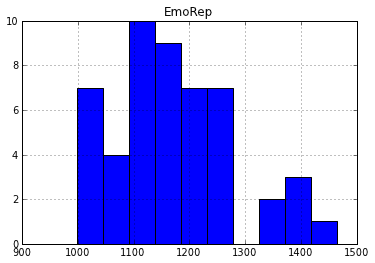

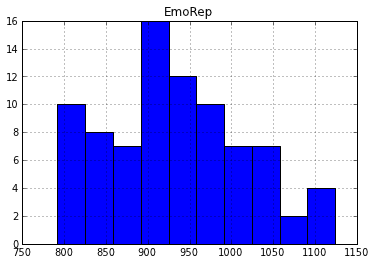

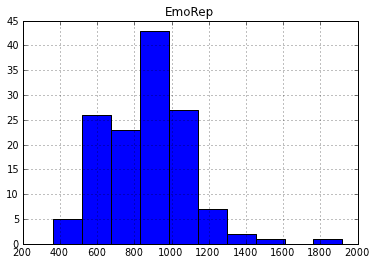

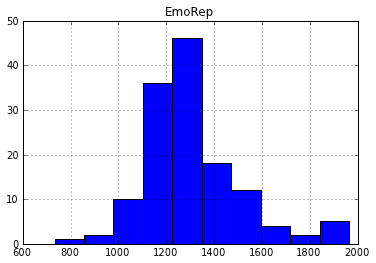

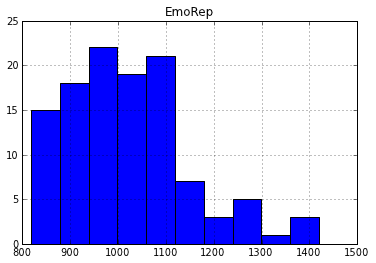

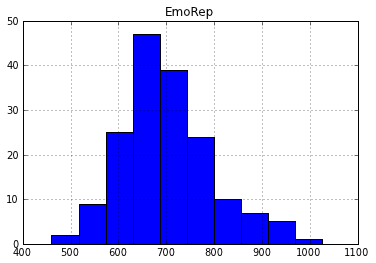

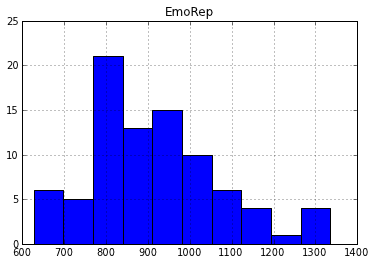

In [74]:
#EmoRep histogram per subject
for x, i in EmoRep.columns:
    EmoRep[x].hist(sharex = True, sharey=True)

AttributeError: 'numpy.ndarray' object has no attribute 'legend'

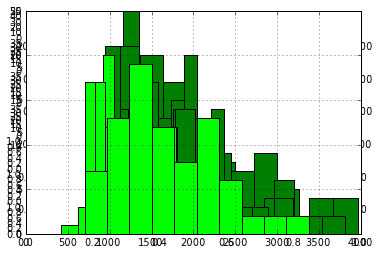

In [75]:
fig, ax = plt.subplots(7)
df['JH10']['EmoRep'].hist(ax = ax[0], color='blue')
df['JH17']['EmoRep'].hist(ax = ax[0],color='blue')
df['JH2']['EmoRep'].hist(ax = ax[0],color='blue')
df['JH6']['EmoRep'].hist(ax = ax[0],color='blue')
df['ST1']['EmoRep'].hist(ax = ax[0],color='blue')
df['GP15']['EmoRep'].hist(ax = ax[0],color='blue')
df['GP28']['EmoRep'].hist(ax = ax[0],color='blue')

df['JH2']['EmoGen'].hist(ax = ax[2],color='cyan')
df['ST1']['EmoGen'].hist(ax = ax[1],color='cyan')
df['GP15']['EmoGen'].hist(ax = ax[1],color='cyan')

df['JH2']['FaceEmo'].hist(ax = ax[2],color='red')
df['JH6']['FaceEmo'].hist(ax = ax[2],color='red')
df['ST1']['FaceEmo'].hist(ax = ax[2],color='red')
df['GP15']['FaceEmo'].hist(ax = ax[2],color='red')

df['JH2']['FaceGen'].hist(ax = ax[3],color='orange')
df['JH6']['FaceGen'].hist(ax = ax[3],color='orange')
df['ST1']['FaceGen'].hist(ax = ax[3],color='orange')
df['GP15']['FaceGen'].hist(ax = ax[3],color='orange')

df['JH10']['SelfAud'].hist(color='green')
df['JH17']['SelfAud'].hist(color='green')
df['JH2']['SelfAud'].hist(color='green')
df['JH6']['SelfAud'].hist(color='green')
df['ST1']['SelfAud'].hist(color='green')
df['ST13']['SelfAud'].hist(color='green')
df['ST15']['SelfAud'].hist(color='green')
df['ST4']['SelfAud'].hist(color='green')
df['GP15']['SelfAud'].hist(color='green')
df['GP27']['SelfAud'].hist(color='green')
df['GP28']['SelfAud'].hist(color='green')

df['JH17']['SelfVis'].hist(color='lime')
df['JH2']['SelfVis'].hist(color='lime')
df['ST13']['SelfVis'].hist(color='lime')
df['GP15']['SelfVis'].hist(color='lime')
df['GP28']['SelfVis'].hist(color='lime')
ax.legend(label= ['EmoRep','EmoGen','FaceEmo','FaceGen','SelfAud','SelfVis'],loc = 'best')


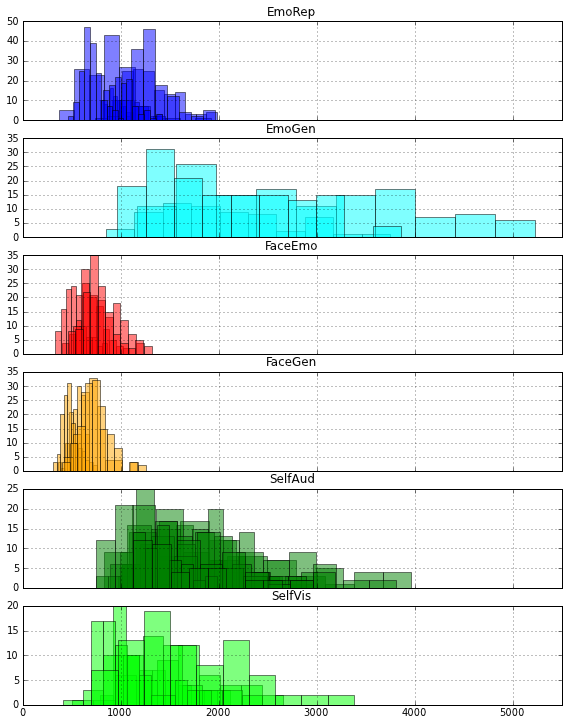

In [736]:
fig, ax = plt.subplots(6, sharex=True, figsize = (8, 10))
plt.xlim((0, 5500))

df['JH10']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['JH17']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['JH2']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['JH6']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['ST1']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['GP15']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)
df['GP28']['EmoRep'].hist(ax = ax[0], color='blue', alpha = 0.5)

df['JH2']['EmoGen'].hist(ax = ax[1],color='cyan', alpha = 0.5)
df['ST1']['EmoGen'].hist(ax = ax[1],color='cyan', alpha = 0.5)
df['GP15']['EmoGen'].hist(ax = ax[1],color='cyan', alpha = 0.5)

df['JH2']['FaceEmo'].hist(ax = ax[2],color='red', alpha = 0.5)
df['JH6']['FaceEmo'].hist(ax = ax[2],color='red', alpha = 0.5)
df['ST1']['FaceEmo'].hist(ax = ax[2],color='red', alpha = 0.5)
df['GP15']['FaceEmo'].hist(ax = ax[2],color='red', alpha = 0.5)

df['JH2']['FaceGen'].hist(ax = ax[3],color='orange', alpha = 0.5)
df['JH6']['FaceGen'].hist(ax = ax[3],color='orange', alpha = 0.5)
df['ST1']['FaceGen'].hist(ax = ax[3],color='orange', alpha = 0.5)
df['GP15']['FaceGen'].hist(ax = ax[3],color='orange', alpha = 0.5)

df['JH10']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['JH17']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['JH2']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['JH6']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['ST1']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['ST13']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['ST15']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['ST4']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['GP15']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['GP27']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)
df['GP28']['SelfAud'].hist(ax = ax[4],color='green', alpha = 0.5)

df['JH17']['SelfVis'].hist(ax = ax[5],color='lime', alpha = 0.5)
df['JH2']['SelfVis'].hist(ax = ax[5],color='lime', alpha = 0.5)
df['ST13']['SelfVis'].hist(ax = ax[5],color='lime', alpha = 0.5)
df['GP15']['SelfVis'].hist(ax = ax[5],color='lime', alpha = 0.5)
df['GP28']['SelfVis'].hist(ax = ax[5],color='lime', alpha = 0.5)

plt.tight_layout()

tasks = ['EmoRep','EmoGen', 'FaceEmo', 'FaceGen', 'SelfAud', 'SelfVis']
for i, t in enumerate(tasks):
    ax[i].set_title(t)
    
plt.savefig('MATLAB/DATA/Avgusta/RThists.png')